Installing tfds (tensorflow dataset) :

In [27]:
!pip install -q tfds-nightly
!tfds --version

2020-12-08 10:10:37.200389: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
TensorFlow Datasets: 4.1.0+nightly


Clone the source repo from GitHub

In [28]:
!git clone "https://github.com/heolfief/Where_is_Waldo_AI_solver.git"

fatal: destination path 'Where_is_Waldo_AI_solver' already exists and is not an empty directory.


Create the images for the dataset

In [36]:
!python Where_is_Waldo_AI_solver/scripts/image_cutter.py

Warning, the following process may be quite long
100% 18/18 [00:03<00:00,  5.91it/s]


Building the dataset from the python script:

In [38]:
!tfds build Where_is_Waldo_AI_solver/scripts/create_TFDS.py --overwrite

2020-12-08 10:11:32.433002: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
I1208 10:11:34.358463 139875625916288 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/waldo_dataset/1.0.0
2020-12-08 10:11:34.363502: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2020-12-08 10:11:34.561462: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
I1208 10:11:34.766619 139875625916288 build.py:345] download_and_prepare for dataset waldo_dataset/1.0.0...
I1208 10:11:34.768494 139875625916288 dataset_builder.py:393] Generating dataset waldo_dataset (/root/tensorflow_datasets/waldo_dataset/1.0.0)
2020-12-08 10:11:34.827567: I tensorflow/core/platform/cloud/google_auth_pr

Testing the dataset :

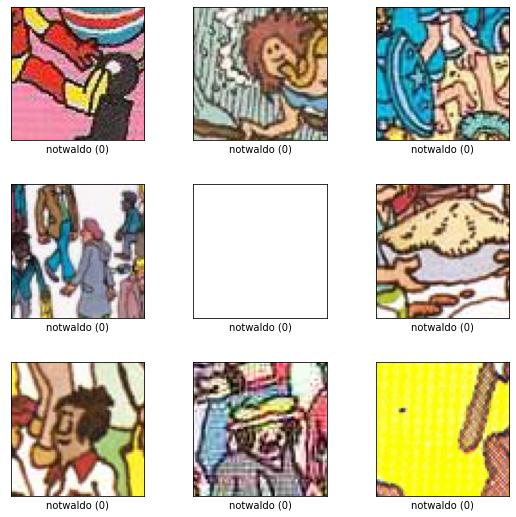

In [58]:
import tensorflow_datasets as tfds
ds, ds_info = tfds.load('waldo_dataset', split='train', with_info=True,  shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds, ds_info)


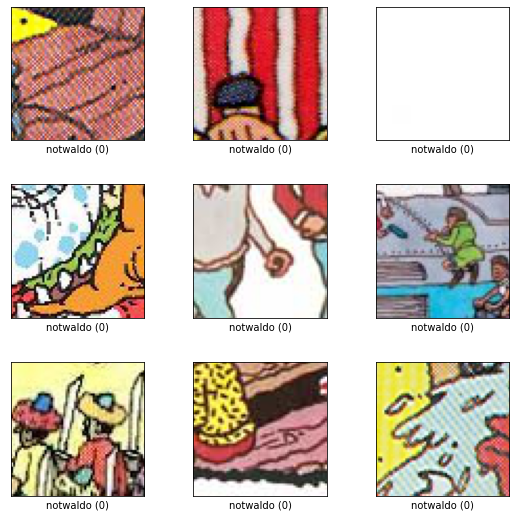

In [64]:
train_size = int(0.7 * ds_info.dataset_size)
val_size = int(0.15 * ds_info.dataset_size)
test_size = int(0.15 * ds_info.dataset_size)


ds = ds.shuffle(1000)
train_dataset = ds.take(train_size)
test_dataset = ds.skip(train_size)
val_dataset = ds.skip(val_size)
test_dataset = ds.take(test_size)

fig = tfds.show_examples(ds, ds_info)


**Build CNN :**

In the menu "Execution" -> modify execution type and select GPU. Once execution type is correctly configured, the GPU model should appaers below 

In [65]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12824974505050801888, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7798962227427562420
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15863855955557803470
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17152053011142889190
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

Load dataset in a dataset class :

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten
import time

train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(32)

In [74]:
CNN = Sequential()
CNN.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(64,64,3)))
CNN.add(MaxPooling2D(pool_size=(2, 2)))

CNN.add(Conv2D(32, (5, 5), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))

CNN.add(Flatten())
# add 3 hiden layers 
# TO DO
CNN.add(Dense(units=84, activation='tanh'))
CNN.add(Dense(units=2, activation='softmax'))
#CNN.add(Dense(units=10, activation='softmax'))

CNN.summary()

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)



CNN.fit(train_dataset, epochs=100, validation_data=test_dataset)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 60, 60, 64)        4864      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 32)        51232     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 84)                454356    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                

In [75]:

print("Evaluate on test data")
results = CNN.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test data
57/57 [==============================] - 0s 2ms/step - loss: 0.1734 - accuracy: 0.9587
test loss, test acc: [0.1734422743320465, 0.95870041847229]


[[1741    0]
 [  75    0]]


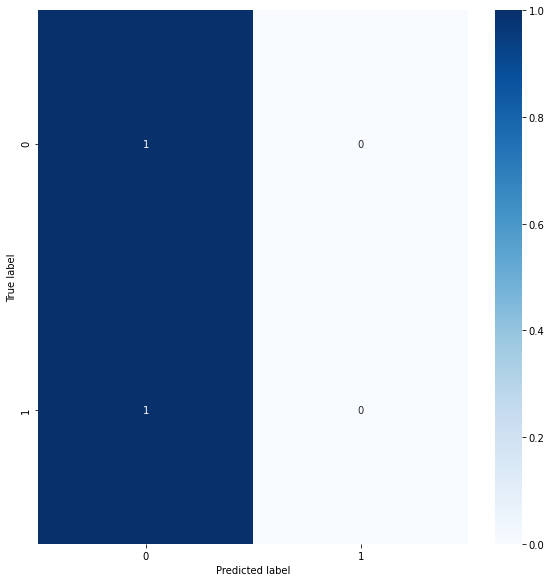

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_pred=CNN.predict_classes(test_dataset)
true_categories = tf.concat([y for x, y in test_dataset], axis=0)
con_mat = tf.math.confusion_matrix(labels=true_categories, predictions=y_pred).numpy()
print(con_mat)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = [0, 1]
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
